# Linear Programming

In [1]:
import numpy as np
import pandas as pd
import random
import warnings
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
import plotly.express as px
%run data_cleaning.ipynb

In [2]:
# import data
#centroid_locations = pd.read_csv(r"C:\Users\dodie\Downloads\spring 2024\trio-capstone\data\CensusTractCentroids.csv")
#metro_locations = pd.read_csv(r"C:\Users\dodie\Downloads\spring 2024\trio-capstone\data\MetroLinkStations_REGISTERED.csv")
#north_south_locations = pd.read_csv(r"C:\Users\dodie\Downloads\spring 2024\trio-capstone\data\MetroLinkStations_NS.csv")
#census_data = data = pd.read_csv(r"C:\Users\dodie\Downloads\spring 2024\trio-capstone\data\B08119_stl_city.csv")
#race_data = pd.read_csv(r"C:\Users\dodie\Downloads\spring 2024\trio-capstone\data\B08105_stl_city.csv")

centroid_locations = pd.read_csv("/Users/dylanmack/Library/CloudStorage/OneDrive-WashingtonUniversityinSt.Louis/ESE 499/trio-capstone/data/CensusTractCentroids.csv")
metro_locations = pd.read_csv("/Users/dylanmack/Library/CloudStorage/OneDrive-WashingtonUniversityinSt.Louis/ESE 499/trio-capstone/data/MetroLinkStations_REGISTERED.csv")
north_south_locations = pd.read_csv("/Users/dylanmack/Library/CloudStorage/OneDrive-WashingtonUniversityinSt.Louis/ESE 499/trio-capstone/data/MetroLinkStations_NS.csv")
census_data = data = pd.read_csv("/Users/dylanmack/Library/CloudStorage/OneDrive-WashingtonUniversityinSt.Louis/ESE 499/trio-capstone/data/B08119_stl_city.csv")
race_data = pd.read_csv("/Users/dylanmack/Library/CloudStorage/OneDrive-WashingtonUniversityinSt.Louis/ESE 499/trio-capstone/data/B08105_stl_city.csv")

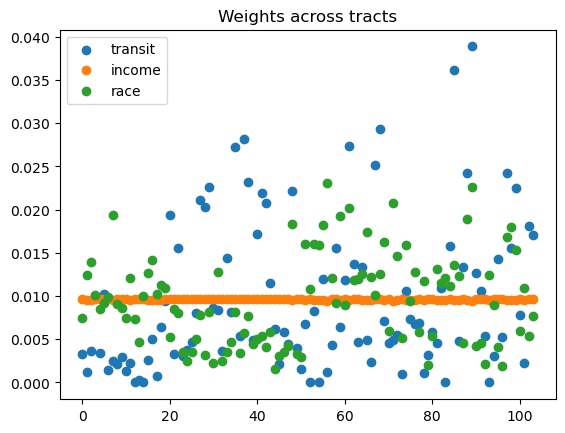

In [3]:
# clean and observe data
by_tract = clean(census_data, race_data)

plt.scatter(by_tract.index, by_tract['transit weight'], label='transit')
plt.scatter(by_tract.index, by_tract['income weight'], label='income')
plt.scatter(by_tract.index, by_tract['race weight'], label='race')
plt.legend()
plt.title('Weights across tracts')
plt.show()

In [4]:
# merge census tract location data with census data

centroid_locations_small = centroid_locations[['NAMELSAD','INTPTLAT','INTPTLON']]
centroid_locations_small = centroid_locations_small.rename(columns = {"NAMELSAD": "location", "INTPTLAT" : "LAT", "INTPTLON" : "LON"})

full_data = by_tract.merge(centroid_locations_small, on='location')
full_data.head()

,location,estimate,transit weight,income weight,race weight,LAT,LON
0,Census Tract 1011,1039,0.003275,0.009653,0.007499,38.554718,-90.273620
1,Census Tract 1012,1921,0.001162,0.009570,0.012480,38.561824,-90.274863
2,Census Tract 1013,2161,0.003697,0.009560,0.013909,38.566560,-90.264211
3,Census Tract 1014,1502,0.010036,0.009614,0.010099,38.562243,-90.253522
4,Census Tract 1015,1318,0.003381,0.009645,0.008554,38.548544,-90.264511


In [5]:
north_south_locations.head()

,id,Name,LON,LAT
0,1,Grand Blvd/Fairground Park,-90.217,38.661
1,2,Palm St/Salisbury St,-90.209,38.658
2,3,St Louis Ave,-90.211,38.653
3,4,Cass Ave,-90.213,38.645
4,5,Carr St,-90.213,38.640


In [6]:
k = 12
n = len(full_data)
x0 = []
for i in range(k):
    new_tract = random.randint(0,n-1)
    x0.append(full_data['LON'][new_tract])
    x0.append(full_data['LAT'][new_tract])

In [7]:
lat_bounds = (min(full_data['LAT']),max(full_data['LAT']))
lon_bounds = (min(full_data['LON']),max(full_data['LON']))
bnds = [val for pair in zip([lon_bounds]*12, [lat_bounds]*12) for val in pair]

In [8]:
def distances_to_nearest_stop(tract_locations, metro_locations):
    
    shortest_distance = np.zeros(len(tract_locations))
    metro_locations = [[metro_locations[i], metro_locations[i + 1]] for i in range(0, len(metro_locations), 2)] # reshape back into 2d array
    
    for i in range(len(tract_locations)):
        cent = np.array([tract_locations['LON'][i],tract_locations['LAT'][i]])
        closest_distance = float('inf') # initialize to infinity
        for j in range(len(metro_locations)):
            metro = np.array(metro_locations[j])
            distance = np.linalg.norm(cent-metro)
            if (distance < closest_distance):
                closest_distance = distance
        shortest_distance[i] = closest_distance
    
    return shortest_distance

In [9]:
def orth_dist(x):
    x = [[x[i], x[i + 1]] for i in range(0, len(x), 2)] # reshape back into 2d array
    longs = np.array([s[0] for s in x]).reshape(-1,1)
    lats = np.array([s[1] for s in x])
    model = LinearRegression().fit(longs,lats)
    b = model.intercept_
    m = model.coef_[0]
    dists = 0
    for stop in x:
        n = abs(-1*m*stop[0] + stop[1] - b)
        d = np.sqrt(m**2+1)
        dists = dists + n/d
    return dists

In [10]:
def distances_between_stops(metro_locations):
    metro_locations = [[metro_locations[i], metro_locations[i + 1]] for i in range(0, len(metro_locations), 2)] # reshape back into 2d array
    shortest_distance = np.zeros(len(metro_locations))
    total_distance = 0
    for i in range(len(metro_locations)):
        metro_current = np.array([metro_locations[i][0],metro_locations[i][1]])
        closest_distance = float('inf') # initialize to infinity
        for j in range(len(metro_locations)):
            if (i != j):
                metro_compared = np.array(metro_locations[j])
                distance = np.linalg.norm(metro_current-metro_compared)
                if (distance < closest_distance):
                    closest_distance = distance
        total_distance = total_distance + closest_distance
    return total_distance

In [11]:
def distance_to_mean_x(metro_locations):
    metro_locations = [[metro_locations[i], metro_locations[i + 1]] for i in range(0, len(metro_locations), 2)] # reshape back into 2d array
    longs = np.array([s[0] for s in metro_locations])
    x_avg = np.mean(longs)
    deviation_from_avg = 0
    for i in range(len(metro_locations)):
        deviation_from_avg = deviation_from_avg + np.abs(x_avg - metro_locations[i][0])
    return deviation_from_avg

In [30]:
def fun(new_stops):
    #print(f'shape of new stops: {np.shape(new_stops)}')
    weights = full_data['race weight']
    #weights = np.ones(len(full_data))
    #print(weights)
    dist_to_stops = np.dot(weights, distances_to_nearest_stop(full_data, new_stops))
    linearity = orth_dist(new_stops) 
    dist_btw_stops = distances_between_stops(new_stops)
    distance_to_mean = distance_to_mean_x(new_stops)
    #print(linearity)
    #print(f'dist to stops: {dist_to_stops:3.3f}, linearity: {linearity:3.3f}')
    return 5*dist_to_stops + 0*linearity - 1.0*dist_btw_stops + 2*distance_to_mean

In [31]:
result = minimize(fun, x0, bounds=bnds)
all_centroids = result.x
lp_results = [[all_centroids[i], all_centroids[i + 1]] for i in range(0, len(all_centroids), 2)]

In [32]:
cluster_centroids = pd.DataFrame(data = lp_results, columns = ["long", "lat"])
cluster_centroids['size'] = [1 for i in range(len(cluster_centroids))]

fig = px.scatter_mapbox(cluster_centroids,
                        lat='lat',
                        lon='long',
                        size='size',
                        size_max=15,
                        zoom=10,
                        height=750)
fig.update_layout(mapbox_style="open-street-map")

In [122]:
print(f'Final Objective Function Value: {result.fun}')

def dist_to_nearest_stop_eval(centroid_locations, metro_locations):
    shortest_distance = np.zeros(len(centroid_locations))
    
    for i in range(len(centroid_locations)):
        cent = np.array([centroid_locations.INTPTLAT[i],centroid_locations.INTPTLON[i]])
        closest_distance = float('inf') # initialize to infinity
        for j in range(len(metro_locations)):
            metro = np.array([metro_locations[j][1],metro_locations[j][0]])
            distance = np.linalg.norm(cent-metro)
            if (distance < closest_distance):
                closest_distance = distance
        shortest_distance[i] = closest_distance
    
    return shortest_distance

shortest_distance = dist_to_nearest_stop_eval(centroid_locations, lp_results)
print(f'Sum of Nearest Stop Evaluation: {np.sum(shortest_distance)}')


Final Objective Function Value: 0.11659536806784976
Sum of Nearest Stop Evaluation: 3.549804866572325


In [123]:
## PARAMETER SWEEPING

a = np.linspace(0, 100, 5)
b = np.linspace(0, 25, 5)
c = np.linspace(0, 25, 5)
d = np.linspace(0, 25, 5)

obj_fun_values = np.zeros([len(a)*len(b)*len(c)*len(d), 5])

def fun_sweep(new_stops):
    #print(f'shape of new stops: {np.shape(new_stops)}')
    #weights = full_data['race weight']
    weights = np.ones(len(full_data))
    #print(weights)
    dist_to_stops = np.dot(weights, distances_to_nearest_stop(full_data, new_stops))
    linearity = orth_dist(new_stops) 
    dist_btw_stops = distances_between_stops(new_stops)
    distance_to_mean = distance_to_mean_x(new_stops)
    #print(f'dist to stops: {dist_to_stops:3.3f}, linearity: {linearity:3.3f}')
    return i*dist_to_stops + j*linearity - k*dist_btw_stops + l*distance_to_mean

counter = 0
for i in a:
    for j in b:
        for k in c:
            for l in d:
                result = minimize(fun_sweep, x0, bounds=bnds)
                obj_fun_values[counter, 0] = i
                obj_fun_values[counter, 1] = j
                obj_fun_values[counter, 2] = k
                obj_fun_values[counter, 3] = l
                obj_fun_values[counter, 4] = result.fun
                counter = counter + 1
                

KeyboardInterrupt: 

In [ ]:
def fun_opt_coefs(new_stops, a, b, c, d):
    #print(f'shape of new stops: {np.shape(new_stops)}')
    #weights = full_data['race weight']
    weights = np.ones(len(full_data))
    #print(weights)
    dist_to_stops = np.dot(weights, distances_to_nearest_stop(full_data, new_stops))
    linearity = orth_dist(new_stops) 
    dist_btw_stops = distances_between_stops(new_stops)
    distance_to_mean = distance_to_mean_x(new_stops)
    #print(f'dist to stops: {dist_to_stops:3.3f}, linearity: {linearity:3.3f}')
    return a*dist_to_stops + b*linearity - c*dist_btw_stops + d*distance_to_mean

result = minimize(fun_opt_coefs, x0, bounds=bnds)
all_centroids = result.x